<a href="https://colab.research.google.com/github/nika-va/practice/blob/main/06_transfer_learning_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Oct  4 16:55:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    14W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-10-04 16:55:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-04 16:55:20 (92.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data('101_food_classes_10_percent.zip')

--2023-10-04 16:55:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.207, 142.250.4.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  17.8MB/s    in 86s     

2023-10-04 16:56:50 (18.1 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
train_dir = '101_food_classes_10_percent/train'
test_dir = '101_food_classes_10_percent/test'

In [6]:
# walk_through_dir('101_food_classes_10_percent')

In [21]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                                batch_size=BATCH_SIZE,
                                                                                image_size=IMG_SIZE)
test_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                                label_mode='categorical',
                                                                                batch_size=BATCH_SIZE,
                                                                                image_size=IMG_SIZE,
                                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [10]:
checkpoint_path = 'food101_checkpoint/checkpoint.ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                monitor='val_accuracy',
                                                save_best_only=True)

In [13]:
import tensorflow as tf
data_augmentation = tf.keras.Sequential([
    # tf.keras.layers.Rescaling(1/255.),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2)
], name='data_augmentation')

In [25]:
from keras.src.engine.sequential import training
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(101, activation='softmax', name='output_layer')(x)

food_model = tf.keras.Model(inputs, outputs)

food_model.compile(loss='categorical_crossentropy',
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics='accuracy')

In [26]:
food_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_5  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                           

In [34]:
food_model_history = food_model.fit(train_data_all_10_percent,
                                    epochs=5,
                                    validation_data=test_data_all_10_percent,
                                    validation_split=int(0.15*len(test_data_all_10_percent)),
                                    callbacks=checkpoint)

Epoch 1/5
237/237 [==============================] - 123s 517ms/step - loss: 2.1946 - accuracy: 0.5020 - val_loss: 1.8586 - val_accuracy: 0.5467
Epoch 2/5
237/237 [==============================] - 111s 464ms/step - loss: 1.8143 - accuracy: 0.5703 - val_loss: 1.7033 - val_accuracy: 0.5677
Epoch 3/5
237/237 [==============================] - 104s 439ms/step - loss: 1.6143 - accuracy: 0.6120 - val_loss: 1.6202 - val_accuracy: 0.5802
Epoch 4/5
237/237 [==============================] - 101s 426ms/step - loss: 1.4431 - accuracy: 0.6492 - val_loss: 1.5721 - val_accuracy: 0.5880
Epoch 5/5
237/237 [==============================] - 99s 417ms/step - loss: 1.3295 - accuracy: 0.6708 - val_loss: 1.5419 - val_accuracy: 0.5935


In [36]:
food_model_results = food_model.evaluate(test_data_all_10_percent)
food_model_results

790/790 [==============================] - 60s 76ms/step - loss: 1.5419 - accuracy: 0.5935


[1.5419390201568604, 0.5935049653053284]

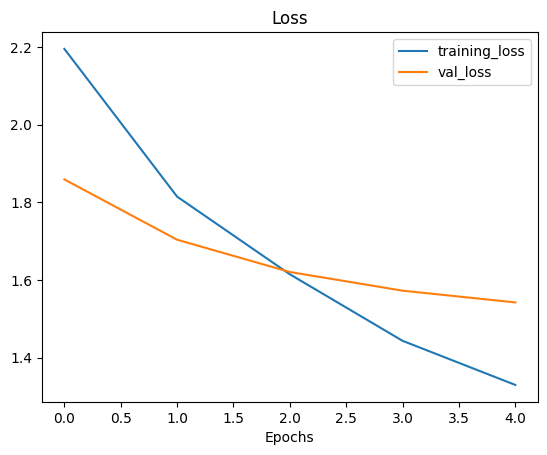

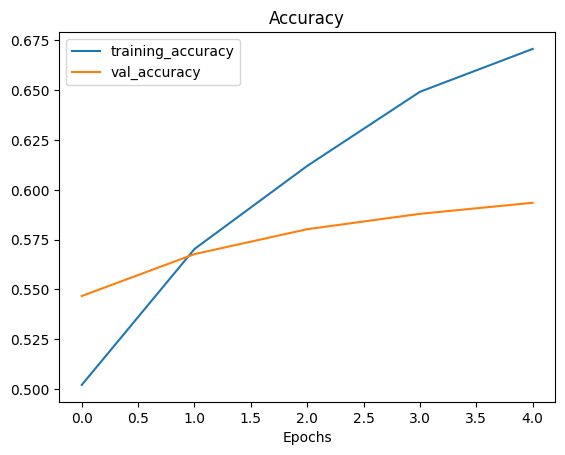

In [38]:
plot_loss_curves(food_model_history)